<h1><center>LSTM Language Detection</center></h1>
<h3><center>CSE 6240 - Websearch and Text Mining</center></h3>

<h7><center>Adam Lieberman, Garrett Mallory, Ravish Chawla</center></h7>
<h7><center>April 25, 2017</center></h7>

1) make 80/20 split on end and frn languages. (lower case all letters)
2) create two lstm models (size 128)
3) train 5 epochs, 0.2 validation split on the training samples 
4) 
4) train on 100 examples of 5 character strings from text with the right label.

pass new word through lstm to get log probability. then do generative log ratio test. y = sign(pe/pj -1) to get the label. Keep scores for ROC.

to get log probability, need p(t), p(r|t), p(u|tr) ... etc. Do this by passing in t, then tr then tru .... This gives you the most likely next character distribution so index into that to get the prob of "U" from "tr".

pass both sets of 100 test (all 200) through both networks for the probability part


In [1]:
from __future__ import print_function;
import sys;
import random;
from random import randint

import numpy as np;

from keras.models import Sequential;
from keras.layers import Dense, Activation;
from keras.layers import LSTM;
from keras.optimizers import RMSprop;
from keras.utils.data_utils import get_file;
from sklearn.cross_validation import train_test_split;
from sklearn.metrics import *;
from sklearn.externals import joblib;

import matplotlib.pyplot as plt;
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, Callback


Using TensorFlow backend.
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [47]:
character = 'é' #'Š'
print (str(character.encode('Latin-1')))

b'a'


In [2]:
english_text = open('data/eng.txt').read().lower()
french_text = open('data/frn.txt').read().lower()

print('English corpus length:', len(english_text))
print('French corpus length:', len(french_text))

English corpus length: 10746
French corpus length: 12009


In [3]:
english_chars = sorted(list(set(english_text)))
french_chars = sorted(list(set(french_text)))

english_char_map = dict((c, i) for i, c in enumerate(english_chars))
french_char_map = dict((c, i) for i, c in enumerate(french_chars))

english_char_map_inverse = dict((i, c) for i, c in enumerate(english_chars))
french_char_map_inverse = dict((i, c) for i, c in enumerate(french_chars))

In [4]:
print('English character count:', len(english_chars))
print('French character count:', len(french_chars))
for c in french_chars:
    if c not in english_chars:
        print("not present:", c)

English character count: 43
French character count: 41
not present: '


In [5]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3

english_sentences = []
english_next_chars = []
for i in range(0, len(english_text) - maxlen, step):
    english_sentences.append(english_text[i: i + maxlen])
    english_next_chars.append(english_text[i + maxlen])

french_sentences = []
french_next_chars = []
for i in range(0, len(french_text) - maxlen, step):
    french_sentences.append(french_text[i: i + maxlen])
    french_next_chars.append(french_text[i + maxlen])
    
print('nb English sequences:', len(english_sentences))
print('nb French sequences:', len(french_sentences))

nb English sequences: 3569
nb French sequences: 3990


In [6]:
print('Vectorization...')

char_len = max(len(english_chars), len(french_chars));

english_x = np.zeros((len(english_sentences), maxlen, char_len), dtype=np.bool)
english_y = np.zeros((len(english_sentences), char_len), dtype=np.bool)
for i, sentence in enumerate(english_sentences):
    for t, char in enumerate(sentence):
        english_x[i, t, english_char_map[char]] = 1
    english_y[i, english_char_map[english_next_chars[i]]] = 1
    
    
french_x = np.zeros((len(french_sentences), maxlen, char_len), dtype=np.bool)
french_y = np.zeros((len(french_sentences), char_len), dtype=np.bool)
for i, sentence in enumerate(french_sentences):
    for t, char in enumerate(sentence):
        french_x[i, t, french_char_map[char]] = 1
    french_y[i, french_char_map[french_next_chars[i]]] = 1

print("Finished!")

Vectorization...
Finished!


In [7]:
english_train_x, english_test_x, english_train_y, english_test_y = train_test_split(english_x, english_y, test_size=0.2, random_state=1024);
french_train_x, french_test_x, french_train_y, french_test_y = train_test_split(french_x, french_y, test_size=0.2, random_state=1024);

In [8]:
print('English Shapes');
print(english_train_x.shape);
print(english_train_y.shape);
print(english_test_x.shape);
print(english_test_y.shape);
print()
print('French Shapes');
print(french_train_x.shape);
print(french_train_y.shape);
print(french_test_x.shape);
print(french_test_y.shape);

English Shapes
(2855, 40, 43)
(2855, 43)
(714, 40, 43)
(714, 43)

French Shapes
(3192, 40, 43)
(3192, 43)
(798, 40, 43)
(798, 43)


In [9]:
class LossHistory(Callback):

    
    def on_train_begin(self, logs={}):
        self.all = {};
        self.all['acc'] = [];
        self.all['val_acc'] = [];
        self.all['loss'] = [];
        self.all['val_loss'] = [];
        pass;
    
    def on_epoch_end(self, batch, logs={}):
        self.all['acc'].append(logs['acc'])
        self.all['val_acc'].append(logs['val_acc'])
        self.all['loss'].append(logs['loss']);
        self.all['val_loss'].append(logs['val_loss']);
            
        clear_output();
        #notify_slack('Finished epoch ' + str(self.num) + ' with ' + str(logs));
        plt.plot(self.all['acc'])
        plt.plot(self.all['val_acc'])


        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        plt.show()
        # summarize history for loss
        plt.plot(self.all['loss'])
        plt.plot(self.all['val_loss'])

        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        plt.show()

In [27]:
# build the model: a single LSTM
def build_model(chars):
    print('Build model...')
    model = Sequential()
    model.add(LSTM(128, input_shape=(None, char_len)))
    model.add(Dense(char_len))
    model.add(Activation('softmax'))
    
    optimizer = RMSprop(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'mse', 'mae']);
    return model

english_model = build_model(english_chars)
french_model = build_model(french_chars);

Build model...
Build model...


In [28]:
history_english = english_model.fit(english_train_x, english_train_y,
                    batch_size=128, epochs=60, validation_split=0.2, shuffle=True);
history_french = french_model.fit(french_train_x, french_train_y,
                    batch_size=128, epochs=60, validation_split=0.2, shuffle=True);

Train on 2284 samples, validate on 571 samples
Epoch 1/60
2284/2284 [==============================] - 2s - loss: 3.1725 - acc: 0.1423 - mean_squared_error: 0.0219 - mean_absolute_error: 0.0438 - val_loss: 2.9472 - val_acc: 0.1629 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.0431
Epoch 2/60
2284/2284 [==============================] - 2s - loss: 2.9314 - acc: 0.1624 - mean_squared_error: 0.0216 - mean_absolute_error: 0.0431 - val_loss: 2.9322 - val_acc: 0.1629 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.0433
Epoch 3/60
2284/2284 [==============================] - 1s - loss: 2.9142 - acc: 0.1629 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0431 - val_loss: 2.9135 - val_acc: 0.1629 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.0429
Epoch 4/60
2284/2284 [==============================] - 2s - loss: 2.9021 - acc: 0.1659 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0430 - val_loss: 2.9155 - val_acc: 0.1629 - val_mean_squar

2553/2553 [==============================] - 2s - loss: 2.7774 - acc: 0.2103 - mean_squared_error: 0.0212 - mean_absolute_error: 0.0425 - val_loss: 2.8347 - val_acc: 0.1831 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.0426
Epoch 6/60
2553/2553 [==============================] - 2s - loss: 2.7575 - acc: 0.2135 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0424 - val_loss: 2.8203 - val_acc: 0.2191 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.0426
Epoch 7/60
2553/2553 [==============================] - 2s - loss: 2.7351 - acc: 0.2307 - mean_squared_error: 0.0210 - mean_absolute_error: 0.0423 - val_loss: 2.7981 - val_acc: 0.1581 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.0422
Epoch 8/60
2553/2553 [==============================] - 2s - loss: 2.7086 - acc: 0.2319 - mean_squared_error: 0.0209 - mean_absolute_error: 0.0421 - val_loss: 2.7857 - val_acc: 0.2316 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.0420
Epoch 9

In [29]:
def random_generate(test_x, key):
    labels = []
    feats = []
    if key == "english": 
        labels = [1 for i in range(100)]
    elif key == 'french': 
        labels = [0 for i in range(100)]
    else:
        return feats, labels;
    
    for i in range(100): 
        r1 = randint(0, len(test_x) - 1)
        ind = test_x[r1]
        
        r2 = randint(0, len(ind) - 5)
        
        sub_string = ind[r2:r2+5]
        
        feats.append(sub_string)
        
    return feats,labels
    
english_sample, english_labels = random_generate(english_test_x, 'english');
french_sample, french_labels = random_generate(french_test_x, 'french');

test_data = np.array(english_sample + french_sample);
test_labels = np.array(english_labels + french_labels);

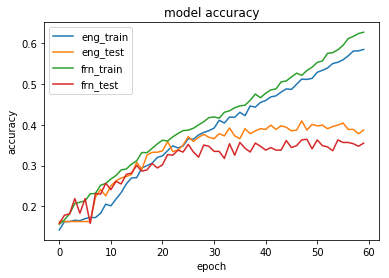

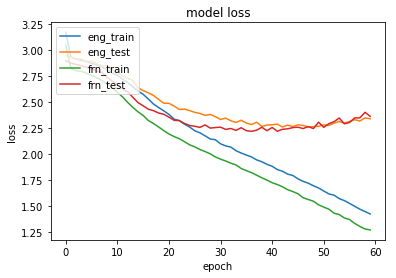

In [30]:
# summarize history for accuracy
plt.plot(history_english.history['acc'])
plt.plot(history_english.history['val_acc'])

plt.plot(history_french.history['acc'])
plt.plot(history_french.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['eng_train', 'eng_test', 'frn_train', 'frn_test'], loc='upper left')
plt.savefig('accuracy_e_60___lr_0.0001___d_0.05.png')

plt.show()
# summarize history for loss
plt.plot(history_english.history['loss'])
plt.plot(history_english.history['val_loss'])

plt.plot(history_french.history['loss'])
plt.plot(history_french.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['eng_train', 'eng_test', 'frn_train', 'frn_test'], loc='upper left')
plt.savefig('loss_e_60___lr_0.0001___d_0.05.png')

plt.show()

In [31]:
def predict_on_sample(model, test_val):
    start = np.zeros((1, 1, char_len), dtype=bool);
    start_prob = model.predict(start);

    next_vec = start.copy()[0][0];
    probs = [];

    probs.append(start_prob[0,np.argwhere(test_val[0])[0][0]]);

    for idx, vec in enumerate(test_val):
        next_vec = np.append(next_vec, vec).reshape(1, idx+2, char_len)
        next_prob = model.predict(next_vec);

        probs.append(next_prob[0, np.argwhere(test_val[idx])[0][0]]);
        
    return np.sum(np.log10(probs));

In [32]:
english_preds = np.array([predict_on_sample(english_model, x) for x in test_data]);

In [33]:
french_preds = np.array([predict_on_sample(french_model, x) for x in test_data]);

In [34]:
ratio_probs = english_preds - french_preds;

In [35]:
ratio_probs_labels = ratio_probs.copy();
ratio_probs_labels[ratio_probs_labels >= 1] = 1;
ratio_probs_labels[ratio_probs_labels < 1] = 0;

In [36]:
roc_auc_score(test_labels, ratio_probs_labels)

0.57499999999999996

In [37]:
accuracy_score(test_labels, ratio_probs_labels)

0.57499999999999996

In [9]:
def something():
    return 6,7,8,9;

In [10]:
x = [something() for x in [1, 2, 3, 4, 5]];

In [12]:
k = 0;

In [21]:
def something():
    return [0,1], [2, 3];

In [22]:
[[a, b], [c,d]] = something()

In [36]:
import random
import sys;

In [37]:
a = random.Random();
b = random.Random();

In [57]:
a.seed(9);
b.seed(sys.maxsize - 9);

In [58]:
for i in range(10):
    print(a.randint(1,100), b.randint(1,100));

60 69
79 76
48 22
35 26
18 85
24 90
87 12
1 35
44 74
65 84


In [59]:
a.seed(9);
b.seed(sys.maxsize - 10);

In [60]:
for i in range(10):
    print(a.randint(1,100), b.randint(1,100));

60 41
79 24
48 31
35 21
18 23
24 52
87 81
1 49
44 90
65 59


In [61]:
a.seed(10);
b.seed(sys.maxsize - 9);

In [62]:
for i in range(10):
    print(a.randint(1,100), b.randint(1,100));

74 69
5 76
55 22
62 26
74 85
2 90
27 12
60 35
63 74
36 84
